In [1]:
import matplotlib
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
matplotlib.rcParams['font.sans-serif'] = "KaiTi"
from datetime import date, datetime

## Souhu 数据接口

搜狐数据接口：

http://q.stock.sohu.com/hisHq?code={code}&start={start}&end={end}，{code}替换为股票代码，大陆股票代码加前缀cn_。{start}替换为起始日期，{end}替换为结束日期。


例如：在浏览器地址栏输入：

http://q.stock.sohu.com/hisHq?code=cn_601766,cn_000002&start=20150601&end=20160414

数组中数据一次对应含义如下：

日期,
今日开盘价,
今日收盘价,
涨跌幅度，
涨跌百分比,
今日最低价,
今日最高价，
今日成交股票手数,
今日成交金额(单位：万)，
换手率

In [2]:
import json
import httpx
from io import StringIO
import pandas as pd

url = "https://q.stock.sohu.com/hisHq?code=cn_600036&start=20240101&end=20250723"
r = httpx.get(url)
data = json.loads(r.text)
stock = data[0]['hq']

json_data = StringIO(json.dumps(stock))

df = pd.read_json(json_data, orient="records")
df.columns = ['日期', '开盘价','收盘价','涨跌幅度', '涨跌百分比','最低价', '最高价', '成交股票手数', '成交金额(单位：万)', '换手率']

df = df.set_index("日期")
df.index = pd.to_datetime(df.index)
print(df)

              开盘价    收盘价  涨跌幅度   涨跌百分比    最低价    最高价   成交股票手数  成交金额(单位：万)  \
日期                                                                          
2025-01-13  38.93  39.07  0.09   0.23%  38.54  39.15   606323   236060.84   
2025-01-10  39.34  38.98 -0.02  -0.05%  38.81  39.45   481425   188166.05   
2025-01-09  39.40  39.00 -0.28  -0.71%  38.83  39.43   447083   174839.92   
2025-01-08  38.83  39.28  0.38   0.98%  38.82  39.55   751481   295294.38   
2025-01-07  38.97  38.90 -0.15  -0.38%  38.61  39.15   492752   191734.48   
...           ...    ...   ...     ...    ...    ...      ...         ...   
2024-01-08  28.17  28.13 -0.16  -0.57%  27.95  28.59   816821   230506.58   
2024-01-05  27.75  28.29  0.48   1.73%  27.62  28.78  1190633   337646.66   
2024-01-04  27.76  27.81  0.04   0.14%  27.36  27.83   637102   175910.16   
2024-01-03  27.58  27.77  0.19   0.69%  27.52  27.84   433956   120038.36   
2024-01-02  27.95  27.58 -0.24  -0.86%  27.56  27.96   542195   150086.55   

开始获取股票数据...
股票数据获取成功！
数据摘要：
              开盘价    收盘价  涨跌幅度   涨跌百分比    最低价    最高价  成交股票手数  成交金额(单位：万)  \
日期                                                                         
2025-01-13  38.93  39.07  0.09   0.23%  38.54  39.15  606323   236060.84   
2025-01-10  39.34  38.98 -0.02  -0.05%  38.81  39.45  481425   188166.05   
2025-01-09  39.40  39.00 -0.28  -0.71%  38.83  39.43  447083   174839.92   
2025-01-08  38.83  39.28  0.38   0.98%  38.82  39.55  751481   295294.38   
2025-01-07  38.97  38.90 -0.15  -0.38%  38.61  39.15  492752   191734.48   

              换手率  
日期                 
2025-01-13  0.29%  
2025-01-10  0.23%  
2025-01-09  0.22%  
2025-01-08  0.36%  
2025-01-07  0.24%  
布林带、MACD、CCI、RSI、ATR和OBV计算完成！
布林带示例数据：
             SMA_20  Upper_Band  Lower_Band
日期                                         
2024-12-16  38.8100   39.977111   37.642889
2024-12-13  38.7215   40.061261   37.381739
2024-12-12  38.7125   40.047359   37.377641
2024-12-11  38.6775   40.017317   37.337

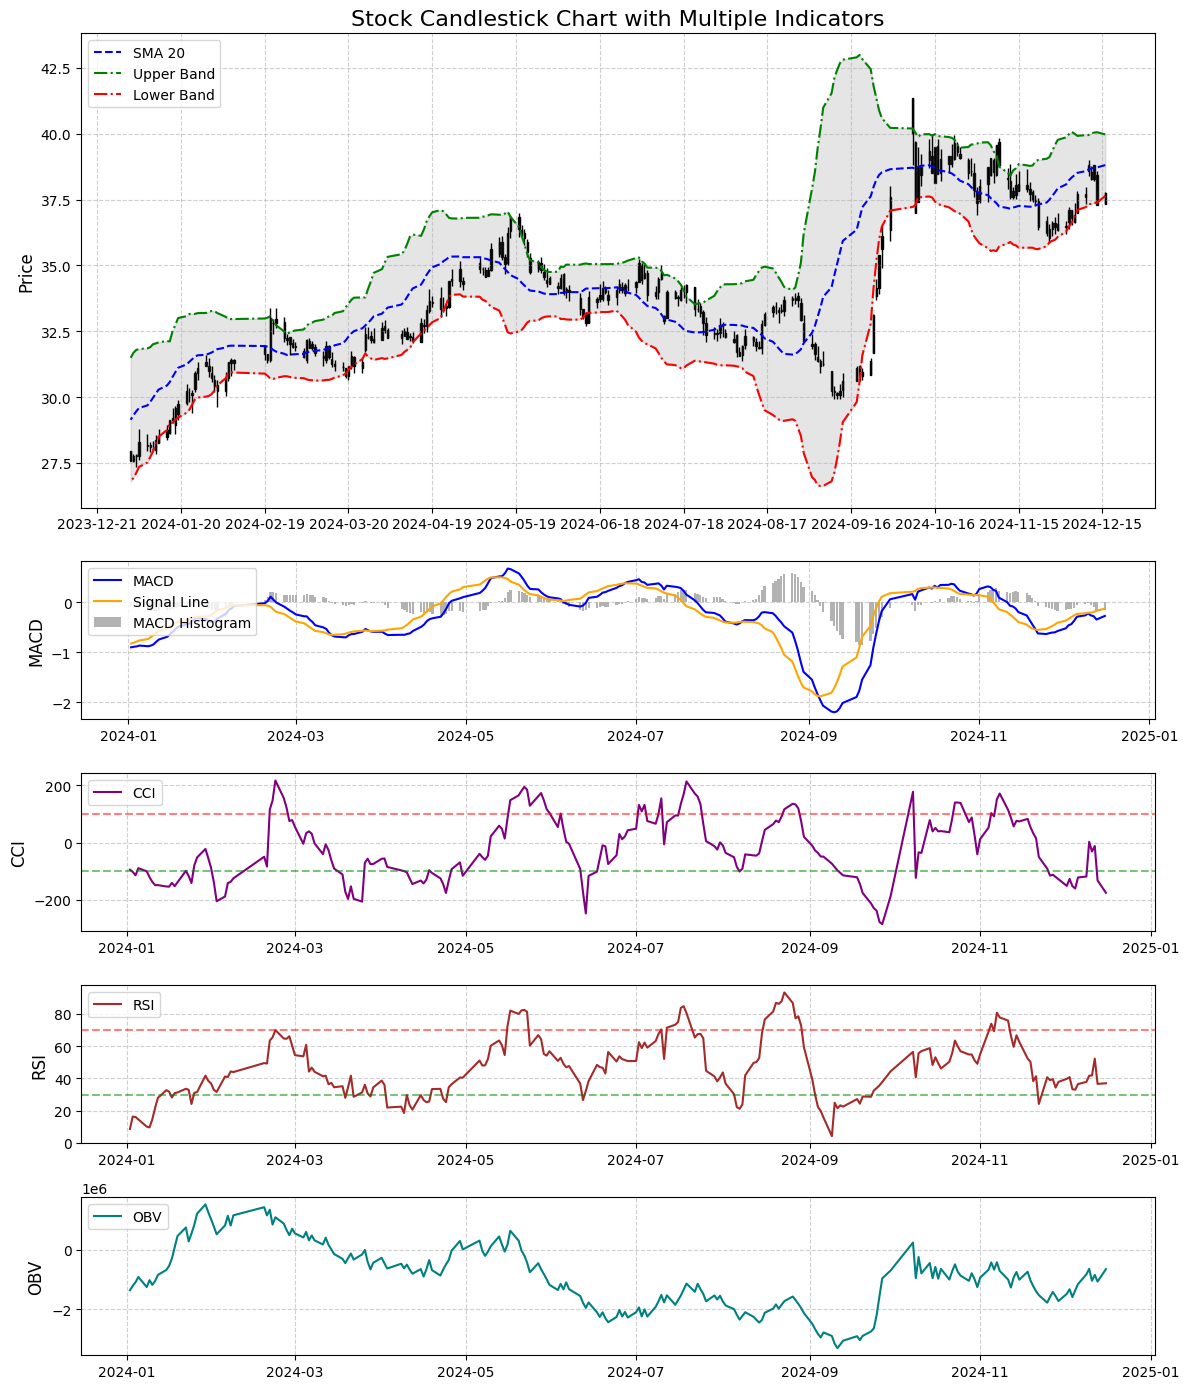

In [2]:
import json
import httpx
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# 打印开始信息
print("开始获取股票数据...")

# 获取股票数据
url = "https://q.stock.sohu.com/hisHq?code=cn_600036&start=20240101&end=20250723"
r = httpx.get(url)
data = json.loads(r.text)
stock = data[0]['hq']

# 打印数据获取成功信息
print("股票数据获取成功！")

# 将数据转换为DataFrame
json_data = StringIO(json.dumps(stock))
df = pd.read_json(json_data, orient="records")
df.columns = ['日期', '开盘价', '收盘价', '涨跌幅度', '涨跌百分比', '最低价', '最高价', '成交股票手数', '成交金额(单位：万)', '换手率']

# 设置日期为索引并转换为datetime格式
df = df.set_index("日期")
df.index = pd.to_datetime(df.index)

# 打印数据摘要
print("数据摘要：")
print(df.head())  # 打印前5行数据

# 重命名列以符合matplotlib的要求
df = df.rename(columns={
    '开盘价': 'Open',
    '收盘价': 'Close',
    '最高价': 'High',
    '最低价': 'Low',
    '成交金额(单位：万)': 'Volume'
})

# 计算20日简单移动平均线（SMA）和布林带
window = 20  # 布林带窗口
df['SMA_20'] = df['Close'].rolling(window=window).mean()
df['STD_20'] = df['Close'].rolling(window=window).std()
df['Upper_Band'] = df['SMA_20'] + 2 * df['STD_20']
df['Lower_Band'] = df['SMA_20'] - 2 * df['STD_20']

# 计算MACD指标
short_ema = df['Close'].ewm(span=12, adjust=False).mean()  # 12日EMA
long_ema = df['Close'].ewm(span=26, adjust=False).mean()   # 26日EMA
df['MACD'] = short_ema - long_ema  # MACD线
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()  # 信号线
df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']  # MACD柱状图

# 计算CCI指标
df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3  # 典型价格
df['SMA_TP'] = df['TP'].rolling(window=20).mean()  # 20日SMA
df['Mean_Deviation'] = df['TP'].rolling(window=20).apply(lambda x: (x - x.mean()).abs().mean())  # 平均偏差
df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['Mean_Deviation'])  # CCI

# 计算RSI指标
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# 计算ATR指标
df['TR1'] = df['High'] - df['Low']  # 真实波动幅度1
df['TR2'] = abs(df['High'] - df['Close'].shift())  # 真实波动幅度2
df['TR3'] = abs(df['Low'] - df['Close'].shift())  # 真实波动幅度3
df['TR'] = df[['TR1', 'TR2', 'TR3']].max(axis=1)  # 真实波动幅度
df['ATR'] = df['TR'].rolling(window=14).mean()  # 14日ATR

# 计算OBV指标
df['OBV'] = (df['Volume'] * (~df['Close'].diff().le(0) * 2 - 1)).cumsum()

# 删除NaN值（前26天数据不足以计算MACD和CCI）
df = df.dropna()

# 打印布林带、MACD、CCI、RSI、ATR和OBV计算结果
print("布林带、MACD、CCI、RSI、ATR和OBV计算完成！")
print("布林带示例数据：")
print(df[['SMA_20', 'Upper_Band', 'Lower_Band']].head())
print("MACD示例数据：")
print(df[['MACD', 'Signal_Line', 'MACD_Histogram']].head())
print("CCI示例数据：")
print(df[['CCI']].head())
print("RSI示例数据：")
print(df[['RSI']].head())
print("ATR示例数据：")
print(df[['ATR']].head())
print("OBV示例数据：")
print(df[['OBV']].head())

# 创建图表
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [3, 1, 1, 1, 1]})

# 绘制蜡烛图
for idx, row in df.iterrows():
    if row['Close'] >= row['Open']:
        color = 'red'  # 上涨为红色
        height = row['Close'] - row['Open']
        bottom = row['Open']
    else:
        color = 'green'  # 下跌为绿色
        height = row['Open'] - row['Close']
        bottom = row['Close']
    ax1.bar(idx, height=height, bottom=bottom, width=0.5, color=color, edgecolor='black')
    ax1.vlines(idx, ymin=row['Low'], ymax=row['High'], color='black', linewidth=1)

# 绘制布林带
ax1.plot(df.index, df['SMA_20'], label='SMA 20', color='blue', linestyle='--')
ax1.plot(df.index, df['Upper_Band'], label='Upper Band', color='green', linestyle='-.')
ax1.plot(df.index, df['Lower_Band'], label='Lower Band', color='red', linestyle='-.')

# 填充布林带区域
ax1.fill_between(df.index, df['Upper_Band'], df['Lower_Band'], color='gray', alpha=0.2)

# 设置蜡烛图属性
ax1.set_title('Stock Candlestick Chart with Multiple Indicators', fontsize=16)
ax1.set_ylabel('Price', fontsize=12)
ax1.legend(loc='upper left')
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30))  # 每30天显示一个日期
ax1.grid(True, linestyle='--', alpha=0.6)  # 网格线样式为虚线，透明度为0.6

# 绘制MACD指标
ax2.plot(df.index, df['MACD'], label='MACD', color='blue')
ax2.plot(df.index, df['Signal_Line'], label='Signal Line', color='orange')
ax2.bar(df.index, df['MACD_Histogram'], label='MACD Histogram', color='gray', alpha=0.6)

# 设置MACD属性
ax2.set_ylabel('MACD', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, linestyle='--', alpha=0.6)  # 网格线样式为虚线，透明度为0.6

# 绘制CCI指标
ax3.plot(df.index, df['CCI'], label='CCI', color='purple')
ax3.axhline(100, color='red', linestyle='--', alpha=0.5)  # CCI上阈值
ax3.axhline(-100, color='green', linestyle='--', alpha=0.5)  # CCI下阈值

# 设置CCI属性
ax3.set_ylabel('CCI', fontsize=12)
ax3.legend(loc='upper left')
ax3.grid(True, linestyle='--', alpha=0.6)  # 网格线样式为虚线，透明度为0.6

# 绘制RSI指标
ax4.plot(df.index, df['RSI'], label='RSI', color='brown')
ax4.axhline(70, color='red', linestyle='--', alpha=0.5)  # RSI上阈值
ax4.axhline(30, color='green', linestyle='--', alpha=0.5)  # RSI下阈值

# 设置RSI属性
ax4.set_ylabel('RSI', fontsize=12)
ax4.legend(loc='upper left')
ax4.grid(True, linestyle='--', alpha=0.6)  # 网格线样式为虚线，透明度为0.6

# 绘制OBV指标
ax5.plot(df.index, df['OBV'], label='OBV', color='teal')

# 设置OBV属性
ax5.set_ylabel('OBV', fontsize=12)
ax5.legend(loc='upper left')
ax5.grid(True, linestyle='--', alpha=0.6)  # 网格线样式为虚线，透明度为0.6

# 保存图表
plt.tight_layout()
# plt.savefig('candlestick_matplotlib.png')

# 打印完成信息
print("蜡烛图绘制完成，已保存为 candlestick_matplotlib.png！")

## 新浪财经基金净值数据

url：

http://stock.finance.sina.com.cn/fundInfo/api/openapi.php/CaihuiFundInfoService.getNav?symbol=040011&datefrom=20220101&dateto=20220723&page=1

接口是分页的形式，需要遍历 page。

```
'日期' => 'fbrq',
'单位净值（元）' => 'jjjz',
'累计净值（元）' => 'ljjz',
```

In [3]:
page = 1
total = pd.DataFrame([])

while True:
    url = f'http://stock.finance.sina.com.cn/fundInfo/api/openapi.php/CaihuiFundInfoService.getNav?symbol=040011&datefrom=20220101&dateto=20250102&page={page}'
    r = httpx.get(url)
    data = json.loads(r.text)
    result = data["result"]["data"]['data']
    if (len(result) == 0):
        break
    json_data = StringIO(json.dumps(result))
    df = pd.read_json(json_data, orient="records")
    total = pd.concat([total, df])
    page = page + 1


total.columns = ['日期', '单位净值（元）', '累计净值（元）']
total = total.set_index('日期')
total.index = pd.to_datetime(total.index)
total

,单位净值（元）,累计净值（元）
日期,,
2025-01-02,1.8305,3.3605
2024-12-31,1.8848,3.4148
2024-12-30,1.9280,3.4580
2024-12-27,1.9230,3.4530
2024-12-26,1.9329,3.4629
...,...,...
2022-01-10,2.9101,4.4401
2022-01-07,2.8996,4.4296
2022-01-06,2.9124,4.4424


## 新浪财经

新浪财经网页地址：https://vip.stock.finance.sina.com.cn/mkt/#hqIndex

url地址：

```
https://vip.stock.finance.sina.com.cn/quotes_service/api/json_v2.php/Market_Center.getHQNodeData?page=1&num=80&sort=symbol&asc=1&node=hs_a&symbol=&_s_r_a=init
```

`node` 参数：hs_a 为沪深A股


In [12]:
url = "https://vip.stock.finance.sina.com.cn/quotes_service/api/json_v2.php/Market_Center.getHQNodeData?page=1&num=80&sort=symbol&asc=1&node=hs_a&symbol=&_s_r_a=init"
r = httpx.get(url)
data = json.loads(r.text)
json_data = StringIO(json.dumps(data))
df = pd.read_json(json_data, orient="records")
df = df.set_index("symbol")
df

,code,name,trade,pricechange,changepercent,buy,sell,settlement,open,high,low,volume,amount,ticktime,per,pb,mktcap,nmc,turnoverratio
symbol,,,,,,,,,,,,,,,,,,,
bj430017,430017,星昊医药,13.57,-0.24,-1.738,13.56,13.57,13.81,13.87,13.90,13.50,868372,11913613,13:58:56,16.155,1.088,1.659451e+05,164284.119400,0.71728
bj430047,430047,诺思兰德,11.19,-0.34,-2.949,11.16,11.19,11.53,11.53,11.55,11.11,1295806,14674558,13:58:56,-58.895,8.981,3.069103e+05,201539.091813,0.71947
bj430090,430090,同辉信息,5.32,-0.20,-3.623,5.33,5.35,5.52,5.54,5.55,5.27,4444473,24202982,13:58:56,-8.276,7.152,1.060454e+05,91236.964196,2.59156
bj430139,430139,华岭股份,23.40,-0.78,-3.226,23.41,23.43,24.18,24.01,24.39,23.05,5397572,128232406,13:58:56,83.571,5.736,6.306473e+05,609878.751300,2.07096
bj430198,430198,微创光电,10.23,-0.19,-1.823,10.21,10.24,10.42,10.34,10.58,10.05,2434722,25250814,13:58:56,-8.597,4.313,1.650752e+05,71859.998694,3.46607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bj832982,832982,锦波生物,203.00,-4.00,-1.932,202.33,203.00,207.00,206.29,208.00,202.26,216552,44200756,13:58:56,43.750,13.643,1.796790e+06,931588.924000,0.47188
bj833030,833030,立方控股,15.29,-0.21,-1.355,15.23,15.29,15.50,15.55,15.95,15.00,858694,13376154,13:58:56,31.204,2.468,1.410399e+05,85541.825424,1.53486
bj833075,833075,柏星龙,26.91,0.18,0.673,26.83,26.91,26.73,26.67,28.00,25.84,2185950,59485593,13:58:56,37.848,4.321,1.744172e+05,66262.511250,8.87740


**基金数据：**

url：

```
https://vip.stock.finance.sina.com.cn/quotes_service/api/json_v2.php/Market_Center.getFundNetData?page=2&num=40&sort=symbol&asc=1&node=open_fund&_s_r_a=page
```


In [7]:
url = "https://vip.stock.finance.sina.com.cn/quotes_service/api/json_v2.php/Market_Center.getFundNetData?page=1&num=80&sort=symbol&asc=1&node=open_fund&_s_r_a=page"
r = httpx.get(url)
data = json.loads(r.text)
json_data = StringIO(json.dumps(data))
df = pd.read_json(json_data, orient="records", dtype={'symbol': str})
df.columns = ["代码", "名称", "最新公布净值", "累计净值", "前单位净值", "净值增长率", "日期", "基金规模份额（亿份）"]
df = df.set_index('代码')
df

,名称,最新公布净值,累计净值,前单位净值,净值增长率,日期,基金规模份额（亿份）
代码,,,,,,,
000001,华夏成长混合A,0.8220,3.3850,0.8360,-1.674641,2024-12-31,30.6684
000003,中海可转债债券A,0.8330,1.0430,0.8420,-1.068884,2024-12-31,0.8822
000004,中海可转债债券C,0.8160,1.0260,0.8250,-1.090909,2024-12-31,0.4549
000005,嘉实增强信用定期债券,1.0350,1.5415,1.0337,0.125762,2024-12-31,2.6893
000006,西部利得量化成长混合A,1.9209,2.2489,1.9543,-1.709052,2024-12-31,4.4580
...,...,...,...,...,...,...,...
000116,嘉实丰益纯债定期债券A,1.0276,1.5443,1.0265,0.107160,2024-12-31,9.9406
000117,广发轮动配置混合,1.9420,1.9420,1.9560,-0.715746,2024-12-31,1.3937
000118,广发聚鑫债券A,1.5255,2.3147,1.5277,-0.144007,2024-12-31,46.2496


**ETF数据：**

url:

```
https://vip.stock.finance.sina.com.cn/quotes_service/api/json_v2.php/Market_Center.getFundNetData?page=3&num=40&sort=symbol&asc=1&node=etf_jz_fund&_s_r_a=page
```

In [8]:
url = "https://vip.stock.finance.sina.com.cn/quotes_service/api/json_v2.php/Market_Center.getFundNetData?page=1&num=80&sort=symbol&asc=1&node=etf_jz_fund&_s_r_a=page"
r = httpx.get(url)
data = json.loads(r.text)
json_data = StringIO(json.dumps(data))
df = pd.read_json(json_data, orient="records", dtype={'symbol': str})
df.columns = ["代码", "名称", "最新公布净值", "累计净值", "前单位净值", "净值增长率", "日期", "基金规模份额（亿份）"]
df = df.set_index('代码')
df

,名称,最新公布净值,累计净值,前单位净值,净值增长率,日期,基金规模份额（亿份）
代码,,,,,,,
159001,易方达保证金货币A,0.3154,3.4740,0.0000,NaN,2024-12-31,0.0279
159003,招商保证金快线A,0.3939,1.4010,0.0000,NaN,2024-12-31,0.0131
159005,汇添富收益快钱货币A,0.3940,1.4930,0.0000,NaN,2024-12-31,0.0042
159150,易方达深证50ETF,1.1849,1.1849,1.2049,-1.659889,2024-12-31,3.1800
159300,富国沪深300ETF,4.0256,1.1227,4.0912,-1.603442,2024-12-31,3.3486
...,...,...,...,...,...,...,...
159521,平安国证2000ETF,0.9590,0.9590,0.9863,-2.767921,2024-12-31,0.6327
159523,华夏中证智选300成长创新策略ETF,1.0123,1.0123,1.0291,-1.632494,2024-12-31,0.7652
159525,富国中证红利低波动ETF,1.0479,1.0479,1.0561,-0.776442,2024-12-31,1.6874
